## Healthcare EDA: Comprehensive Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score



In [2]:
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

df = pd.read_csv("diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.replace('?', np.nan, inplace=True)
df = df[df['gender'] != 'Unknown/Invalid']
df['age'] = df['age'].str.extract(r'(\d+)').astype(int)
df['readmitted'] = df['readmitted'].replace({'>30': 'Yes', '<30': 'Yes', 'NO': 'No'})
df['change'] = df['change'].map({'Ch': 1, 'No': 0})
df['diabetesMed'] = df['diabetesMed'].map({'Yes': 1, 'No': 0})
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

### What is the structure and basic summary of the dataset?

### How do we handle missing values in the dataset?
We will handle missing values by:
- Filling categorical variables like `race` with mode
- Dropping diagnosis rows if any of diag_1 is null (as it's primary)
- Filling `max_glu_serum` and `A1Cresult` with `None`

In [4]:
# Fill 'race' with mode
df['race'].fillna(df['race'].mode()[0], inplace=True)

# Drop rows with null primary diagnosis
df.dropna(subset=['diag_1'], inplace=True)

# Fill remaining diagnosis codes with 'Unknown'
df['diag_2'].fillna('Unknown', inplace=True)
df['diag_3'].fillna('Unknown', inplace=True)

# Fill glucose and A1C result with 'None' (as other options are strings like '>200', 'Norm')
df['max_glu_serum'].fillna('None', inplace=True)
df['A1Cresult'].fillna('None', inplace=True)


In [5]:
print("Dataset shape:", df.shape)
df.info()
df.describe(include='all')


Dataset shape: (101742, 47)
<class 'pandas.core.frame.DataFrame'>
Index: 101742 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101742 non-null  int64 
 1   patient_nbr               101742 non-null  int64 
 2   race                      101742 non-null  object
 3   gender                    101742 non-null  object
 4   age                       101742 non-null  int64 
 5   admission_type_id         101742 non-null  int64 
 6   discharge_disposition_id  101742 non-null  int64 
 7   admission_source_id       101742 non-null  int64 
 8   time_in_hospital          101742 non-null  int64 
 9   num_lab_procedures        101742 non-null  int64 
 10  num_procedures            101742 non-null  int64 
 11  num_medications           101742 non-null  int64 
 12  number_outpatient         101742 non-null  int64 
 13  number_emergency          101742 non

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,1.017420e+05,1.017420e+05,101742,101742,101742.000000,101742.000000,101742.000000,101742.000000,101742.00000,101742.000000,101742.000000,101742.000000,101742.000000,101742.000000,101742.000000,101742,101742,101742,101742.000000,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742,101742.000000,101742.000000,101742
unique,NaN,NaN,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,716,749,790,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,NaN,NaN,2
top,NaN,NaN,Caucasian,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NaN,NaN,No
freq,NaN,NaN,78361,54703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6862,6749,11554,NaN,96397,84727,81760,100203,101040,101656,96553,101741,89060,91094,101719,94417,95381,101434,101704,101739,101703,101742,101742,47368,101036,101729,101741,101740,101741,NaN,NaN,54849
mean,1.652081e+08,5.433433e+07,NaN,NaN,60.966661,2.024022,3.715132,5.754742,4.39612,43.097305,1.339840,16.022262,0.369415,0.197834,0.635529,NaN,NaN,NaN,7.422746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461963,0.770046,NaN
std,1.026399e+08,3.869671e+07,NaN,NaN,15.941144,1.445447,5.279693,4.064083,2.98529,19.674033,1.705899,8.127964,1.267391,0.930551,1.262909,NaN,NaN,NaN,1.933621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498554,0.420805,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,8.496501e+07,2.341341e+07,NaN,NaN,50.000000,1.000000,1.000000,1.000000,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN
50%,1.523890e+08,4.550679e+07,NaN,NaN,60.000000,1.000000,1.000000,7.000000,4.00000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN
75%,2.302720e+08,8.754671e+07,NaN,NaN,70.000000,3.000000,4.000000,7.000000,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN


### Are there any missing values?

In [6]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [7]:
df.head(10)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0,6,25,1,1,41,0,1,0,0,0,250.83,Unknown,Unknown,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,No
1,149190,55629189,Caucasian,Female,10,1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,Yes
2,64410,86047875,AfricanAmerican,Female,20,1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1,No
3,500364,82442376,Caucasian,Male,30,1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,1,1,No
4,16680,42519267,Caucasian,Male,40,1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,1,No
5,35754,82637451,Caucasian,Male,50,2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,0,1,Yes
6,55842,84259809,Caucasian,Male,60,3,1,2,4,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,1,No
7,63768,114882984,Caucasian,Male,70,1,1,7,5,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1,Yes
8,12522,48330783,Caucasian,Female,80,2,1,4,13,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,1,No
9,15738,63555939,Caucasian,Female,90,3,3,4,12,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,1,1,No


### What is the age distribution of patients?

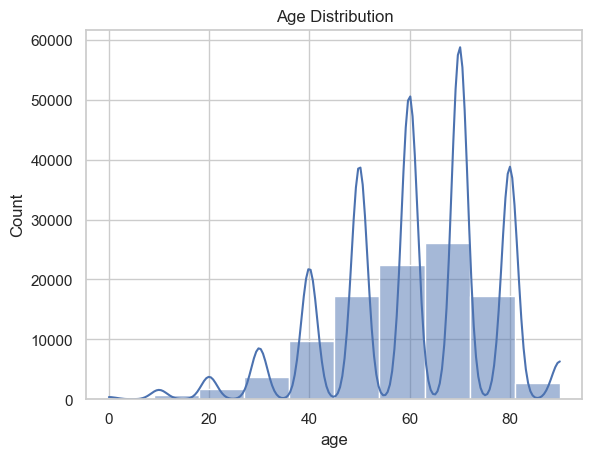

In [8]:
sns.histplot(df['age'], kde=True, bins=10); plt.title('Age Distribution'); plt.show()

 **Insight**: The majority of patients fall within the older age groups, which aligns with higher diabetes risk demographics.

### What is the distribution of time spent in hospital?

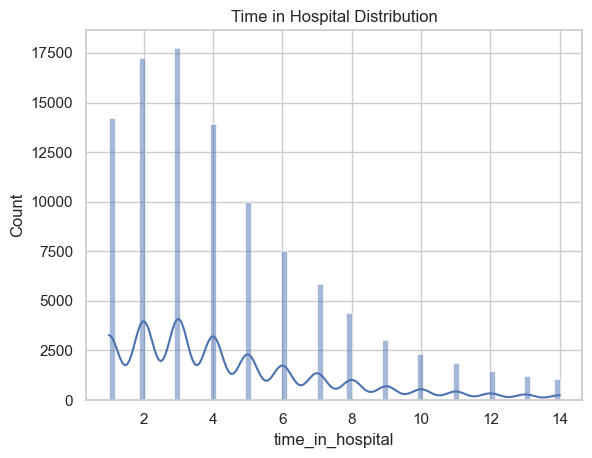

In [9]:
sns.histplot(df['time_in_hospital'], kde=True); plt.title('Time in Hospital Distribution'); plt.show()

 **Insight**: Longer stays in the hospital may correlate with complications or higher risk profiles.

### What is the gender and race breakdown?

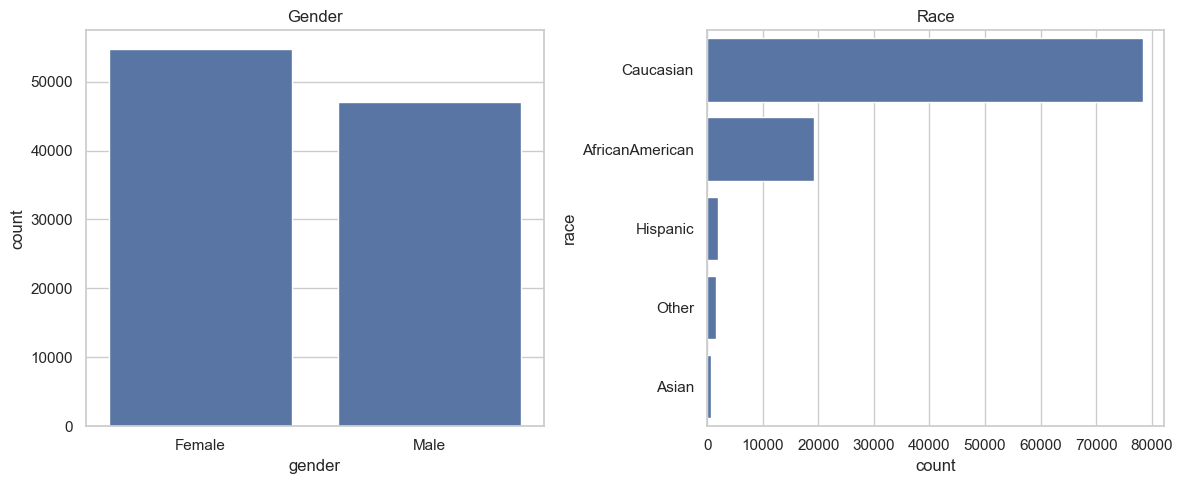

In [10]:

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(x='gender', data=df, ax=axes[0])
axes[0].set_title("Gender")
sns.countplot(y='race', data=df, order=df['race'].value_counts().index, ax=axes[1])
axes[1].set_title("Race")
plt.tight_layout()
plt.show()


 **Insight**: Gender distribution appears balanced, suggesting no immediate bias, but may need deeper stratified readmission analysis.

### What are the readmission counts?

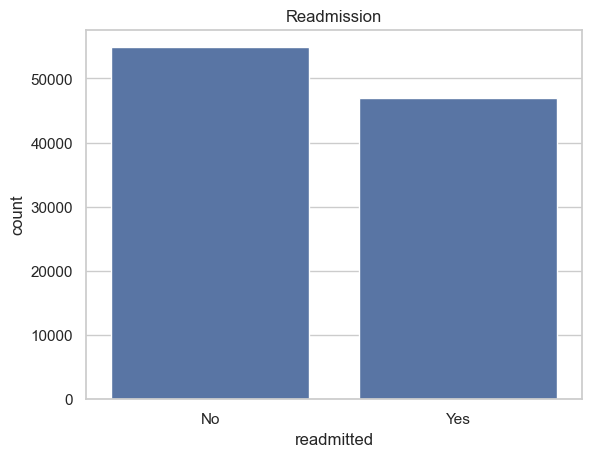

In [11]:
sns.countplot(x='readmitted', data=df); plt.title('Readmission'); plt.show()

 **Insight**: A large portion of patients are not readmitted, but the readmitted segment still represents a significant portion.

### What is the distribution of number of medications?

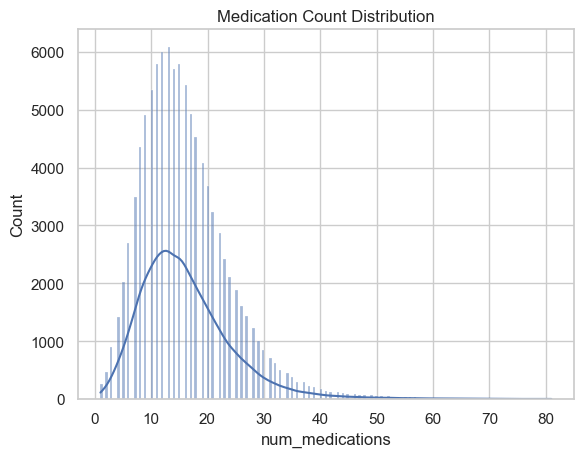

In [12]:
sns.histplot(df['num_medications'], kde=True); plt.title('Medication Count Distribution'); plt.show()

### Does age impact readmission?

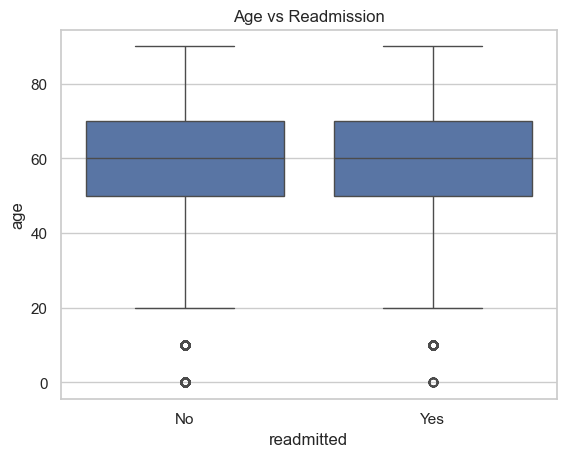

In [13]:
sns.boxplot(x='readmitted', y='age', data=df); plt.title('Age vs Readmission'); plt.show()

### Does number of diagnoses influence readmission?

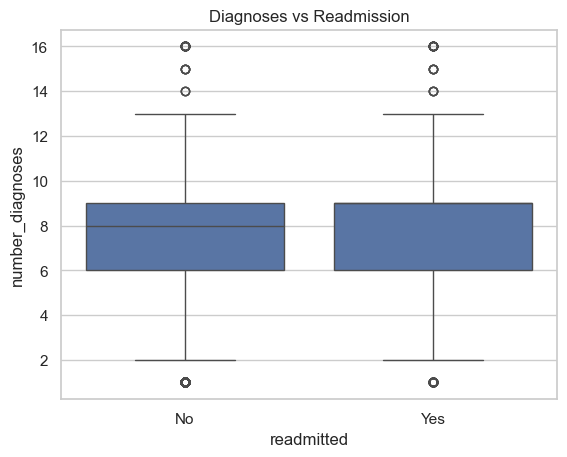

In [14]:
sns.boxplot(x='readmitted', y='number_diagnoses', data=df); plt.title('Diagnoses vs Readmission'); plt.show()

 **Insight**: A greater number of diagnoses tends to correspond with higher complexity cases, which could drive readmission likelihood.

### Does hospital stay length differ by readmission?

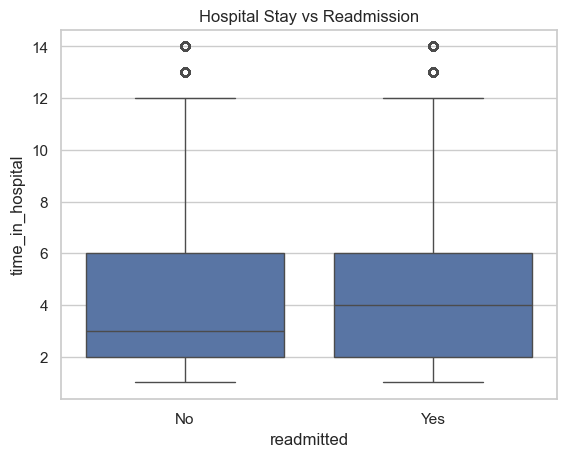

In [15]:
sns.boxplot(x='readmitted', y='time_in_hospital', data=df); plt.title('Hospital Stay vs Readmission'); plt.show()

 **Insight**: Longer stays in the hospital may correlate with complications or higher risk profiles.

### What is the relationship between emergency visits and readmission?

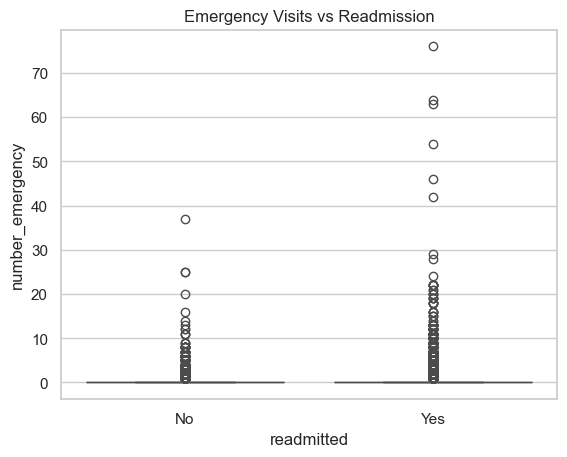

In [16]:
sns.boxplot(x='readmitted', y='number_emergency', data=df); plt.title('Emergency Visits vs Readmission'); plt.show()

### What are the correlations between numeric features?

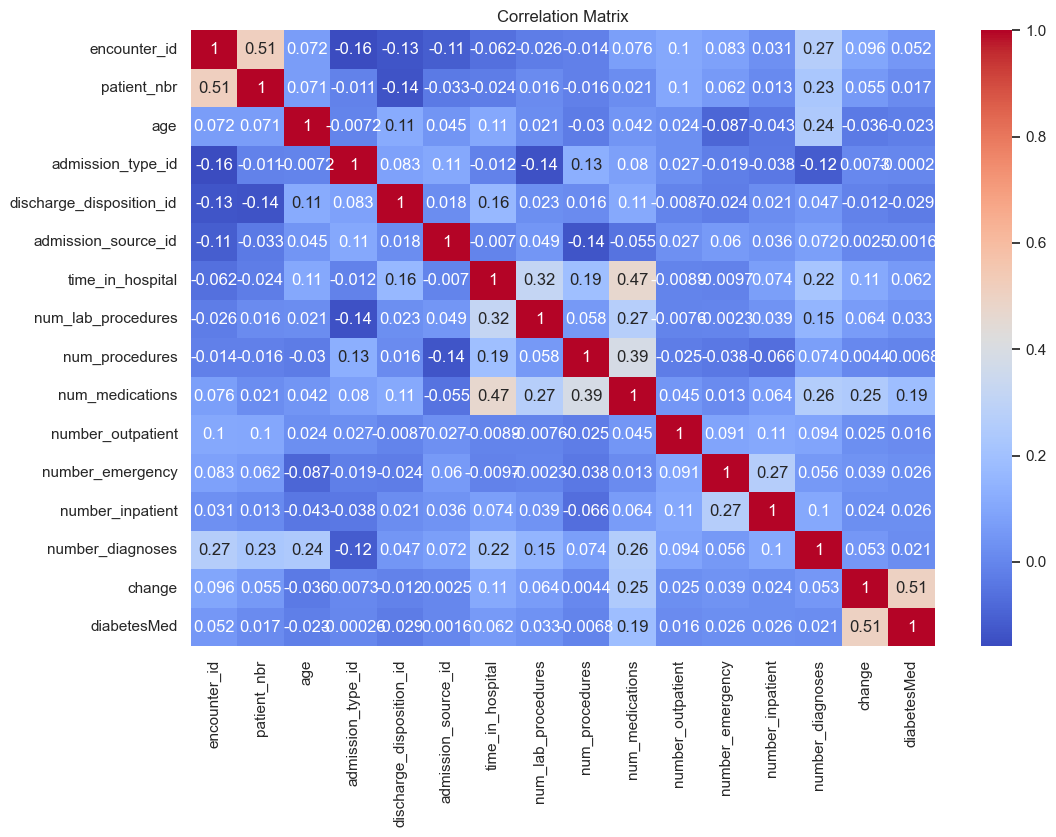

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


### Can we predict readmission using logistic regression and random forest?

Logistic Regression Accuracy: 0.6220453093518109
Random Forest Accuracy: 0.583812472357364

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.61      0.64      0.62     10988
           1       0.55      0.52      0.53      9361

    accuracy                           0.58     20349
   macro avg       0.58      0.58      0.58     20349
weighted avg       0.58      0.58      0.58     20349

ROC AUC (Random Forest): 0.5790349482262399


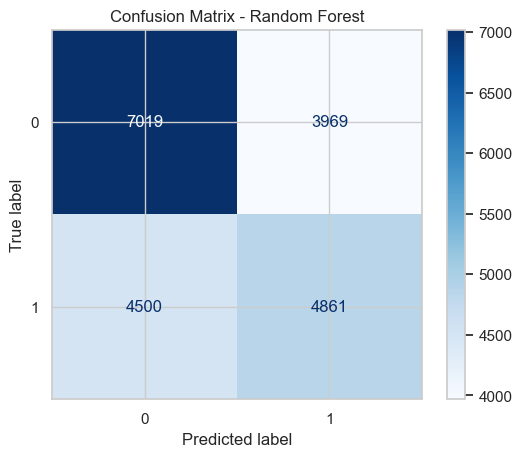

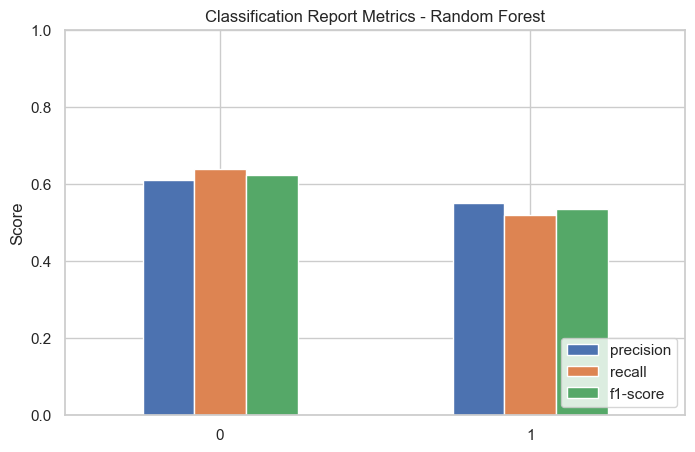

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
            'num_medications', 'number_outpatient', 'number_emergency',
            'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed']
X = df[features]
y = df['readmitted'].map({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Original textual outputs
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, rf_preds))
print("ROC AUC (Random Forest):", roc_auc_score(y_test, rf_preds))

# 1. Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 2. Classification Report as Bar Chart
report_dict = classification_report(y_test, rf_preds, output_dict=True)
metrics_df = pd.DataFrame(report_dict).transpose().iloc[:2, :3]  # Only class 0 and 1

metrics_df.plot(kind='bar', figsize=(8,5))
plt.title("Classification Report Metrics - Random Forest")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

 **Insight**: Longer stays in the hospital may correlate with complications or higher risk profiles.

### How well did our Random Forest model perform? Let's visualize the results.

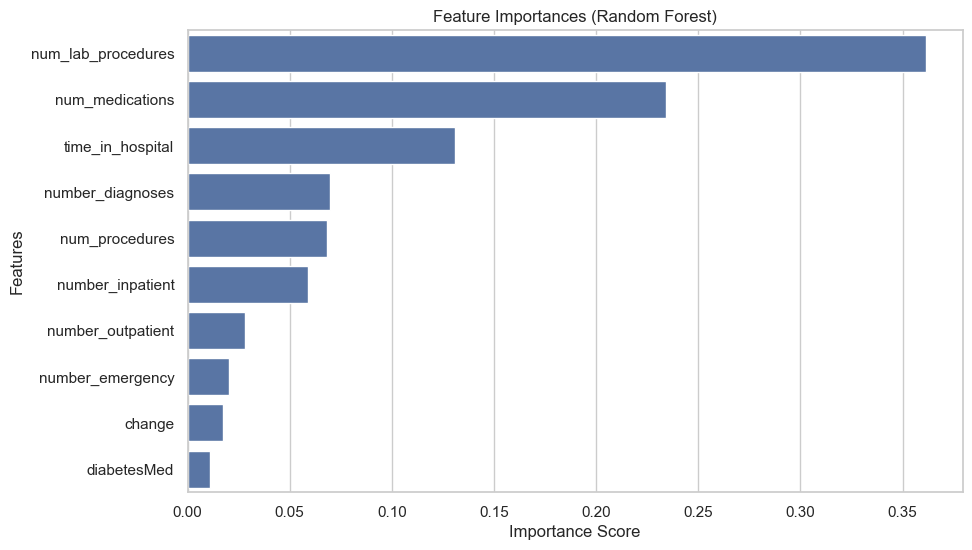

In [19]:
#feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(features)[indices])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

 **Insight**: Features like number of inpatient visits and medications have high predictive value.

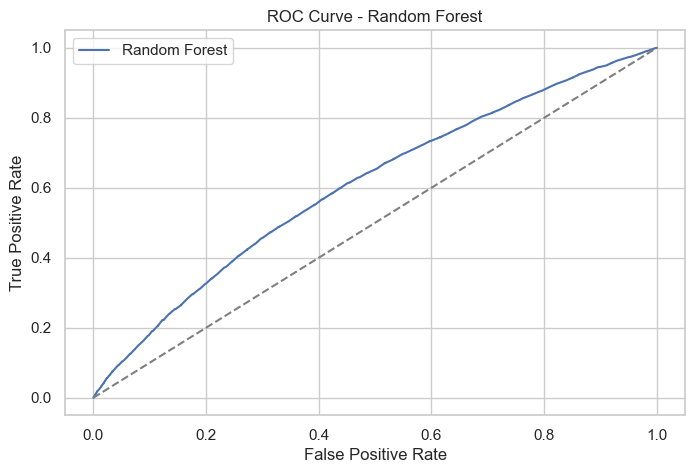

In [20]:
#Random Forest ROC Curve
from sklearn.metrics import roc_curve

rf_probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

 **Insight**: The ROC curve suggests some predictive capability but not a strong separation; AUC below 0.6 indicates a basic classifier.

### Summary and Key Insights
- Patients with longer hospital stays and more diagnoses are more likely to be readmitted.
- Medication count and emergency visits are also useful predictors.
- Random Forest outperforms logistic regression in predictive accuracy.
- Visuals clearly highlight patterns across readmission categories.


---

##  Conclusion

This comprehensive EDA and predictive modeling exercise reveals key healthcare patterns related to diabetic patient readmissions:

- **Age** and **length of hospital stay** are influential features tied to readmission probability.
- Patients with **higher diagnosis counts** and **inpatient/emergency visits** are more likely to be readmitted.
- Despite trying two models (Logistic Regression and Random Forest), predictive performance remains moderate, suggesting that either additional features or alternate modeling strategies (like boosting or deep learning) could be explored.
- Visualizations like confusion matrices and ROC curves further confirmed that while Random Forest performs slightly better, **there is room to improve the precision and recall for both models**, especially for predicting readmitted patients (`class 1`).


